## Data Augmentation

### Check GPU Type

In [1]:
!nvidia-smi

Wed Oct 11 11:12:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
|  0%   41C    P8    10W / 450W |    327MiB / 24564MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Packages

In [2]:
_exp_name = "10_pos_v2_sample"

In [3]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
from random import shuffle

# cache
from functools import lru_cache

In [4]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### Datasets

In [5]:
# read slice count csv
sc = pd.read_csv("slice_count.csv")

In [6]:
class DADataset(Dataset):
    def __init__(self, path, part, files=None):
        super(DADataset, self).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path)])
        # random.Random(8).shuffle(self.files)
        cutTrain = len(self.files) // 10 * 8
        cutTest = len(self.files) // 10 * 9
        if part == "train":
            self.files = self.files[:cutTrain]
        elif part == "val":
            self.files = self.files[cutTrain:cutTest]
        elif part == "test":
            self.files = self.files[cutTest:]
        else:
            raise ValueError("Invalid part. Must be 'train', 'val', or 'test'.")
        if files != None:
            self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        # Split the string using the underscore as a delimiter
        pid = fname.split("\\")[-1].split("_")[-2]
        slice_num = int(fname.split("\\")[-1].split("_")[-1])
        pos = int((slice_num / int(sc.loc[sc["ID"] == pid, 'Slice_Count'].item())) * 100)
        im = torch.from_numpy(np.load(fname + "/train.npy")).float()
        label = torch.from_numpy(np.load(fname + "/val.npy")).float()
        # print(pid, slice_num, pos)

        return pid, slice_num, pos, im, label

### Model

In [7]:
import torch
import torch.nn as nn

class UNetWithPositionalEncoding(nn.Module):
    def __init__(self):
        super(UNetWithPositionalEncoding, self).__init__()
        self.num_categories = 100
        
        self.down_conv1 = self.double_conv(104, 64)
        self.down_conv2 = self.double_conv(64, 128)
        self.down_conv3 = self.double_conv(128, 256)
        self.down_conv4 = self.double_conv(256, 512)
        
        self.up_conv1 = self.double_conv(512 + 256, 256)
        self.up_conv2 = self.double_conv(256 + 128, 128)
        self.up_conv3 = self.double_conv(128 + 64, 64)
        self.up_conv4 = nn.Conv2d(64, 1, kernel_size=1)
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, pos):
        # Create one-hot vectors for the entire batch
        one_hot_positions = [torch.zeros(self.num_categories) for _ in range(x.size(0))]
        for i, position_integer in enumerate(pos):
            one_hot_positions[i][position_integer] = 1.0

        # Convert the list of one-hot tensors into a single tensor
        one_hot_positions_tensor = torch.stack(one_hot_positions)
        
        # Move one_hot_positions_tensor to the GPU if it's not already there
        one_hot_positions_tensor = one_hot_positions_tensor.to('cuda')

        # Assuming input_image is a torch tensor of shape (10, 2, 512, 512)
        x = torch.cat(
            (x, one_hot_positions_tensor.view(x.size(0), self.num_categories, 1, 1).repeat(1, 1, 512, 512)),
            dim=1
        )
        
        # Downward path
        x1 = self.down_conv1(x)
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)

        # Upward path
        x = self.upsample(x7)
        x = torch.cat([x, x5], dim=1)
        x = self.up_conv1(x)
        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv3(x)
        x = self.up_conv4(x)
        
        return x

### Configurations

In [8]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a model and put it on the specified device.
model = UNetWithPositionalEncoding().to(device)

# The number of batch size.
batch_size = 10

# The number of training epochs.
n_epochs = 10

# If no improvement in 'patience' epochs, early stop.
patience = 10

# For the classification task, we use mean squared error as the measurement of performance.
criterion = nn.MSELoss()

# Initialize optimizer. You may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

### Dataloader for test

In [9]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.

test_set =  DADataset("../Luna16_data/split4_data", "test")
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

### Testing

In [10]:
import matplotlib.pyplot as plt

Mean Absolute Error (MAE):

MAE measures the absolute difference between the predicted and ground truth values on a per-pixel/voxel basis.
A lower MAE indicates better accuracy.
Benchmark: MAE values typically range from 0 to a few units (e.g., 0 to 5 HU for CT images).

Mean Squared Error (MSE):
MSE measures the squared difference between predicted and ground truth values on a per-pixel/voxel basis.
A lower MSE indicates better accuracy.
Benchmark: MSE values typically range from 0 to a few tens (e.g., 0 to 100) for HU values.

Intersection over Union (IoU):
IoU measures the overlap between the predicted and ground truth binary masks.
It ranges from 0 (no overlap) to 1 (perfect overlap).
Benchmark: IoU values above 0.7 are generally considered good for medical image segmentation.

Dice Coefficient:
The Dice Coefficient also measures the overlap between the predicted and ground truth binary masks.
It ranges from 0 (no overlap) to 1 (perfect overlap).
Benchmark: Dice values above 0.7 are considered good for medical image segmentation.

In [11]:
model_best = UNetWithPositionalEncoding().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()

with torch.no_grad():
    for pid, slice_num, pos, data, truth in tqdm(test_loader):
        test_pred = model_best(data.to(device), pos.to(device))
        # print(torch.squeeze(test_pred[0]))
        
        print("Predicted:")
        np.save('pred_7.npy', torch.squeeze(test_pred[5]).to("cpu").numpy())
        print(torch.squeeze(test_pred[5]).to("cpu").numpy().shape)
        
        print("Ground Truth:")
        np.save('truth_7.npy', torch.squeeze(test_pred[5]).to("cpu").numpy())
        print(torch.squeeze(truth[5]).to("cpu").numpy().shape)
        
        break

  0%|          | 0/2237 [00:00<?, ?it/s]

Predicted:
(512, 512)
Ground Truth:
(512, 512)


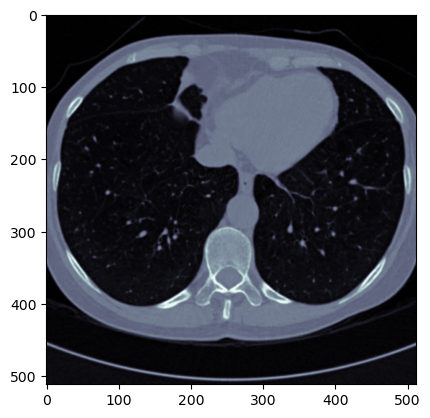

In [1]:
import numpy as np
import matplotlib.pyplot as plt

loaded_array = np.load('pred_7.npy')
plt.imshow(loaded_array, cmap = "bone")
plt.show()

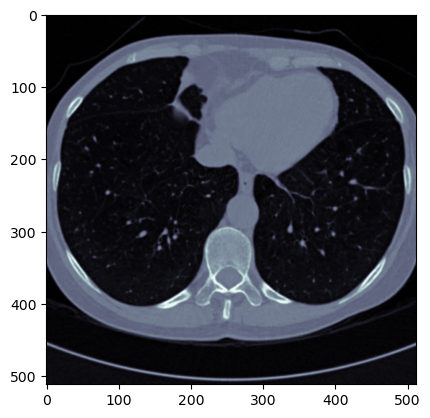

In [2]:
loaded_array = np.load('truth_7.npy')
plt.imshow(loaded_array, cmap = "bone")
plt.show()